## Importing Libraries

In [135]:
import numpy as np
import pandas as pd
import paramiko
import matplotlib.pyplot as plt
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import itertools
import pickle

## Making a connection to EMR
Define a function to connect to EC2 instance on which HDFS storage is hosted and run hive commands to extract the data to train the model

In [45]:
def hive_query_executor():
    dns_name = 'ec2-54-209-251-228.compute-1.amazonaws.com'
    k = paramiko.RSAKey.from_private_key_file("EMR.pem")
    conn_obj = paramiko.SSHClient()
    conn_obj.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    # connect to server use pem
    conn_obj.connect(dns_name, username="hadoop",pkey=k)
    # query the whole table
    Hive_query_c="select * from mydb.fakenewstraining;"
    query_execute_command_c = 'hive -e "' + Hive_query_c + '"'
    stdin1, stdout1, stderr1 = conn_obj.exec_command(query_execute_command_c)
    out1 = ''
    # convert the table to string and use stringIO to further generate Dataframe
    for line1 in stdout1:
        out1 = out1 + line1
    df = pd.read_csv(io.StringIO(out1), sep="\t", lineterminator='\n', header=None)
    conn_obj.close()
    return df

In [46]:
res = hive_query_executor()

In [47]:
res

,0,1,2,3,4
0,100,Activist Post,Technocracy: The Real Reason Why The UN Wants ...,"By Patrick Wood By its very nature, the Intern...",1
1,101,Matt Richtel,American Drivers Regain Appetite for Gas Guzzl...,The single most effective action that most Ame...,0
2,102,Nicholas Confessore and Rachel Shorey,"Hillary Clinton Builds $150 Million War Chest,...",Donald J. Trump entered the homestretch of the...,0
3,103,Amanda Shea,Trump Catches What Sick Reporter Snuck In Inte...,Trump Catches What Sick Reporter Snuck In Inte...,1
4,104,Joel B. Pollak,All 100 Senators Contacted Russian Government ...,Attorney General Jeff Sessions found himself a...,0
...,...,...,...,...,...
20695,20795,Jerome Hudson,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0
20696,20796,Benjamin Hoffman,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0
20697,20797,Michael J. de la Merced and Rachel Abrams,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0
20698,20798,Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1


## Cleaning data
Renaming the columns and cleaning the data

In [48]:
res.rename(columns={0: 'id', 1: 'author', 2: 'title', 3: 'text', 4: 'label'}, inplace=True)

In [49]:
news_dataset=res

In [51]:
news_dataset.head()

,id,author,title,text,label
0,100,Activist Post,Technocracy: The Real Reason Why The UN Wants ...,"By Patrick Wood By its very nature, the Intern...",1
1,101,Matt Richtel,American Drivers Regain Appetite for Gas Guzzl...,The single most effective action that most Ame...,0
2,102,Nicholas Confessore and Rachel Shorey,"Hillary Clinton Builds $150 Million War Chest,...",Donald J. Trump entered the homestretch of the...,0
3,103,Amanda Shea,Trump Catches What Sick Reporter Snuck In Inte...,Trump Catches What Sick Reporter Snuck In Inte...,1
4,104,Joel B. Pollak,All 100 Senators Contacted Russian Government ...,Attorney General Jeff Sessions found himself a...,0


In [52]:
# remove the rows where text is NA
news_dataset = news_dataset.dropna(subset=['text'])

In [53]:
# Fill NA with ''
news_dataset = news_dataset.fillna('')

In [54]:
news_dataset.isnull().sum()

id        0
author    0
title     0
text      0
label     0
dtype: int64

In [55]:
# Concatenate author, title and text together for the TFIDF Vectorizer
news_dataset['text_corpus'] = news_dataset['author']+' '+news_dataset['title']+' '+news_dataset['text']

In [56]:
print(news_dataset['text_corpus'])

0        Activist Post Technocracy: The Real Reason Why...
1        Matt Richtel American Drivers Regain Appetite ...
2        Nicholas Confessore and Rachel Shorey Hillary ...
3        Amanda Shea Trump Catches What Sick Reporter S...
4        Joel B. Pollak All 100 Senators Contacted Russ...
                               ...                        
20695    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20696    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20697    Michael J. de la Merced and Rachel Abrams Macy...
20698    Alex Ansary NATO, Russia To Hold Parallel Exer...
20699    David Swanson What Keeps the F-35 Alive   Davi...
Name: text_corpus, Length: 20572, dtype: object


In [118]:
# keep all the data with only 1 0 in the label
texttokeep = ['1','0']

In [119]:
# drop missing rows
news_dataset=news_dataset[news_dataset.label.isin(texttokeep)]

In [121]:
# Split data set to X and Y variables
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [122]:
X = news_dataset['text_corpus']
print(X)

0        Activist Post Technocracy: The Real Reason Why...
1        Matt Richtel American Drivers Regain Appetite ...
2        Nicholas Confessore and Rachel Shorey Hillary ...
3        Amanda Shea Trump Catches What Sick Reporter S...
4        Joel B. Pollak All 100 Senators Contacted Russ...
                               ...                        
20695    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20696    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20697    Michael J. de la Merced and Rachel Abrams Macy...
20698    Alex Ansary NATO, Russia To Hold Parallel Exer...
20699    David Swanson What Keeps the F-35 Alive   Davi...
Name: text_corpus, Length: 19675, dtype: object


In [123]:
news_dataset['label']

0        1
1        0
2        0
3        1
4        0
        ..
20695    0
20696    0
20697    0
20698    1
20699    1
Name: label, Length: 19675, dtype: object

In [124]:
news_dataset["label"] = pd.to_numeric(news_dataset["label"])

In [125]:
# Separating data and label
X = news_dataset['text_corpus'].values
Y = news_dataset['label'].values

In [126]:
news_dataset['text_corpus']

0        Activist Post Technocracy: The Real Reason Why...
1        Matt Richtel American Drivers Regain Appetite ...
2        Nicholas Confessore and Rachel Shorey Hillary ...
3        Amanda Shea Trump Catches What Sick Reporter S...
4        Joel B. Pollak All 100 Senators Contacted Russ...
                               ...                        
20695    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20696    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20697    Michael J. de la Merced and Rachel Abrams Macy...
20698    Alex Ansary NATO, Russia To Hold Parallel Exer...
20699    David Swanson What Keeps the F-35 Alive   Davi...
Name: text_corpus, Length: 19675, dtype: object

In [127]:
Y

array([1, 0, 0, ..., 0, 1, 1])

## Start the Model Building

In [128]:
# Use Tfidf and remove the stop words
vectorizer = TfidfVectorizer(stop_words='english')

# convert the words to numeric features and store them in sparse matrix
Tfidmodel = vectorizer.fit(X)
X = Tfidmodel.transform(X)

In [129]:
print(X)

  (0, 141860)	0.23424743750225216
  (0, 139245)	0.14187284178583542
  (0, 127454)	0.32692997761980835
  (0, 127451)	0.36225065239830295
  (0, 111582)	0.12637647708307892
  (0, 106024)	0.131731084605529
  (0, 105878)	0.11616667059293236
  (0, 102253)	0.19314601333176387
  (0, 100498)	0.11927736343424057
  (0, 96212)	0.19917306332287152
  (0, 93273)	0.1426295047405709
  (0, 91085)	0.1555630409140729
  (0, 90101)	0.16776203945206655
  (0, 88219)	0.1598431876920928
  (0, 87797)	0.16968052563860803
  (0, 65667)	0.32628764647859854
  (0, 62581)	0.35785856706205066
  (0, 45477)	0.2147085003456028
  (0, 30389)	0.21000827159500918
  (0, 29886)	0.12308456412403498
  (0, 11476)	0.22172128707435143
  (0, 5165)	0.18111356138412749
  (1, 143402)	0.022716268621013506
  (1, 143080)	0.011465760366510465
  (1, 143070)	0.035909769664109636
  :	:
  (19674, 6585)	0.02841916483270928
  (19674, 6514)	0.01603898066917508
  (19674, 6432)	0.03960677792893467
  (19674, 5327)	0.018916379112948953
  (19674, 5165)	

In [130]:
# Check the words in each article
vectorizer.inverse_transform(X)

[array(['wood', 'wants', 'technocrats', 'technocracy', 'run', 'reason',
        'real', 'profit', 'post', 'patrick', 'organization', 'numbers',
        'non', 'nature', 'names', 'internet', 'icann', 'exclusively',
        'corporation', 'control', 'assigned', 'activist'], dtype='<U91'),
 array(['york', 'years', 'year', 'xc90', 'worry', 'worried', 'worldwide',
        'works', 'won', 'wife', 'widespread', 'went', 'weeks', 'week',
        'way', 'watershed', 'warming', 'wants', 'want', 'votes', 'volvo',
        'views', 'view', 'version', 'vehicles', 've', 'vans', 'utility',
        'university', 'united', 'trying', 'trucks', 'trouble',
        'transportation', 'transform', 'transferring', 'traded', 'toyota',
        'total', 'times', 'time', 'thought', 'think', 'thing', 'tesla',
        'technology', 'tank', 'tailpipe', 'swapalease', 'sustainable',
        'surged', 'sui', 'stronger', 'sterman', 'stations', 'states',
        'state', 'starting', 'start', 'spur', 'sport', 'spells',
    

In [131]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=18)

In [132]:
# Function to plot confusion Matrix
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [133]:
# fit random forest
clf = RandomForestClassifier(n_estimators = 1000, random_state = 11, n_jobs=-1)
clf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=11)

In [136]:
# F1 Score on Training Data
X_train_prediction = clf.predict(X_train)
training_data_accuracy = f1_score(X_train_prediction, Y_train)

print('F1 score on the training data: ',training_data_accuracy)

# F1 Score on Test Data
X_test_prediction = clf.predict(X_test)
test_data_accuracy = f1_score(X_test_prediction, Y_test)

print('F1 score on the test data: ',test_data_accuracy)

F1 score on the training data:  1.0
F1 score on the test data:  0.9449035812672176


Confusion matrix, without normalization


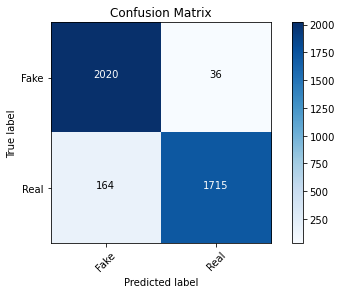

In [137]:
cm = metrics.confusion_matrix(Y_test, X_test_prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [138]:
# save the model
filename = 'Tfidmodel.sav'
pickle.dump(Tfidmodel, open(filename, 'wb'))

In [139]:
# save the model
filename = 'randomForest_model.sav'
pickle.dump(clf, open(filename, 'wb'))